## Imports

In [1]:
import googlemaps
import pandas as pd
import numpy as np
import re
import os
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from pyproj import CRS
import math
from shapely.ops import cascaded_union
from shapely.geometry import Polygon

## Imports

In [2]:
pd.set_option('display.max_columns',None)

## Links

Miami-Dade data download: https://gis-mdc.opendata.arcgis.com/datasets/MDC::property-boundary-view/about
DOR Use code descriptions: https://gis-mdc.opendata.arcgis.com/datasets/MDC::dor-code/explore

Palm Beach data download: https://opendata2-pbcgov.opendata.arcgis.com/datasets/PBCGOV::property-information-table/explore

Broward Property Appraiser "Contact Us" page: https://bcpa.net/phone.asp

## Data read-in

In [3]:
# Read in geographic data
MiamiDade_geo = gpd.read_file('miamidade_2022pin')
PalmBeach_geo = gpd.read_file('palmbeach_2022pin')
Broward_geo = gpd.read_file('broward_2022pin')

In [4]:
So_Fla_geo_list = [MiamiDade_geo,PalmBeach_geo,Broward_geo]

In [5]:
So_Fla_geo = gpd.GeoDataFrame(pd.concat(So_Fla_geo_list,ignore_index=True))

In [6]:
# Set the desired CRS
target_crs = CRS.from_epsg(4326)

# Change it to the desired crs
So_Fla = So_Fla_geo.to_crs(target_crs)

In [7]:
# Load in Property Appraiser data
MiamiDade_data = gpd.read_file('NAL23F202201.dbf')
PalmBeach_data = gpd.read_file('NAL60F202201.dbf')
Broward_data = gpd.read_file('NAL16F202201.dbf')

In [8]:
# Concat non geo dataframes
data_list = [MiamiDade_data,PalmBeach_data,Broward_data]

So_Fla_data = gpd.GeoDataFrame(pd.concat(data_list,ignore_index=True))

In [9]:
# Drop the empty 'geometry' column
So_Fla_data = So_Fla_data.drop(columns='geometry')

## Create Agricultural GeoJSON file

In [10]:
# Convert the 'DOR_UC' code to type int
So_Fla_data['DOR_UC'] = So_Fla_data['DOR_UC'].astype(int)

In [11]:
# Whittle down the data to agricutlrual properties only
So_Fla_data_agri = So_Fla_data[(So_Fla_data['DOR_UC'] >= 50) & (So_Fla_data['DOR_UC'] <= 69)]

In [12]:
merged_So_Fla_agri = pd.merge(So_Fla_data_agri,So_Fla, left_on='PARCEL_ID', right_on='PARCELNO', how='inner')

In [13]:
columns_to_keep = ['PARCEL_ID','DOR_UC','PHY_ADDR1','PHY_CITY','geometry']

In [14]:
merged_So_Fla_agri_final = merged_So_Fla_agri[columns_to_keep]

In [15]:
merged_So_Fla_agri_final['PHY_ADDR1'] = merged_So_Fla_agri_final['PHY_ADDR1'].fillna('No Physical Address')

/var/folders/rq/0_j_rksd7psgdycg9c1qwf6m0000gp/T/ipykernel_19042/2304607047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_So_Fla_agri_final['PHY_ADDR1'] = merged_So_Fla_agri_final['PHY_ADDR1'].fillna('No Physical Address')


In [16]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_So_Fla_agri_final, geometry='geometry')

# Save the GeoDataFrame as a GeoJSON file
gdf.to_file('SoFla_agri_final.geojson', driver='GeoJSON')

## SoFla Other Critical Infrastructure Properties

In [86]:
# Create zone descriptions
data = [
    {'DOR_UC':47,'DESC':'Mineral processing, phosphate processing, cement plants, refineries, clay plants, rock and gravel plants.'},
    {'DOR_UC':91,'DESC':'Utility, gas and electricity, telephone and telegraph, locally assessed railroads, water and sewer service, pipelines, canals, radio/television communication.'},
#     {'DOR_UC':96,'DESC':'Sewage disposal, solid waste, borrow pits, drainage reservoirs, waste land, marsh, sand dunes, swamps.'},
    {'DOR_UC':49,'DESC':'Open storage, new and used building supplies, junk yards, auto wrecking, fuel storage, equipment and material storage.'},
    {'DOR_UC':20,'DESC':'Airports (private or commercial), bus terminals, marine terminals, piers, marinas.'},
    {'DOR_UC':81,'DESC':'Military'}
       ]

DOR_desc_df = pd.DataFrame(data)

In [87]:
So_Fla_data.columns

Index(['CO_NO', 'PARCEL_ID', 'FILE_T', 'ASMNT_YR', 'BAS_STRT', 'ATV_STRT',
       'GRP_NO', 'DOR_UC', 'PA_UC', 'SPASS_CD',
       ...
       'CONO_PRV_H', 'PARCEL_ID_', 'YR_VAL_TRN', 'SEQ_NO', 'RS_ID', 'MP_ID',
       'STATE_PAR_', 'SPC_CIR_CD', 'SPC_CIR_YR', 'SPC_CIR_TX'],
      dtype='object', length=116)

In [88]:
## Create DF of only restricted properties
So_Fla_restricted = pd.merge(So_Fla_data, DOR_desc_df, left_on='DOR_UC',right_on='DOR_UC',how='inner')

In [89]:
## Create geoDF of only restricted properties
merged_So_Fla_restricted = pd.merge(So_Fla_restricted,So_Fla, left_on='PARCEL_ID',right_on='PARCELNO',how='inner')

In [90]:
merged_So_Fla_restricted['PHY_ADDR1'] = merged_So_Fla_restricted['PHY_ADDR1'].fillna('No Physical Address')

In [91]:
# Create a GeoDataFrame from the DataFrame
merged_So_Fla_restricted_export = gpd.GeoDataFrame(merged_So_Fla_restricted, geometry='geometry')

# Now you have a GeoDataFrame that you can export as GeoJSON
merged_So_Fla_restricted_export.to_file('restricted_export_final.geojson', driver='GeoJSON')

## Create airport layer

In [70]:
airport_data = [
    {'Airport':'MIA','Folio':'3031290000011','Address':'4250 NW 36 ST, MIAMI-DADE'},
    {'Airport':'HST','Folio':'3079120000010','Address':'28205 SW 125 AVE, MIAMI-DADE'},
    {'Airport':'OPF','Folio':'0821200000010','Address':'14201 NW 42nd Ave, MIAMI-DADE'},
    {'Airport':'FLL','Folio':'504222000311','Address':'100 Terminal Drive, BROWARD'},
    {'Airport':'LNA','Folio':'00434431000001010','Address':'2633 LANTANA RD, PALM BEACH COUNTY'},
    {'Airport':'PBI','Folio':'00434332000001090','Address':'1250 PERIMETER RD, PALM BEACH COUNTY'},
    {'Airport':'F45','Folio':'00414201000005020','Address':'11200 AVIATION BLVD, PALM BEACH COUNTY'}
]

airport_df = pd.DataFrame(airport_data)

In [68]:
airport_df_merged = pd.merge(airport_df,So_Fla_data, left_on='Folio', right_on='PARCEL_ID', how='inner')
airport_df_merged_geo = pd.merge(airport_df_merged,So_Fla, left_on='Folio',right_on='PARCELNO',how='inner')

In [79]:
keep_columns = ['Airport','Folio','Address','geometry']
airport_df_merged_geo = airport_df_merged_geo[keep_columns]

In [81]:
airport_df_merged_geo_export = gpd.GeoDataFrame(airport_df_merged_geo, geometry='geometry') 

airport_df_merged_geo_export.to_file('airport_export_final.geojson', driver='GeoJSON')

## Create buffer

In [92]:
buffer_target_CRS = CRS.from_epsg(32634)

In [93]:
# Change it to the desired crs
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.to_crs(buffer_target_CRS)

In [94]:
merged_So_Fla_restricted_export['extended_geometry'] = merged_So_Fla_restricted_export.geometry.buffer(10 * 1609.34)  # 10 miles in meters

In [95]:
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.drop(columns='geometry')
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.rename(columns={'extended_geometry':'geometry'})

In [96]:
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.to_crs(target_crs)

In [97]:
final_buffer = merged_So_Fla_restricted_export[['CO_NO','geometry']]

In [98]:
final_buffer.to_file('final_buffer.geojson',driver='GeoJSON')

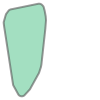

In [99]:
from shapely.geometry import MultiPolygon

# Assuming you have a GeoDataFrame called gdf with a 'geometry' column containing polygons

# Create a single polygon representing the outermost border
outer_polygon = final_buffer['geometry'].unary_union

# Check if the result is a MultiPolygon and convert it to a Polygon if necessary
if isinstance(outer_polygon, MultiPolygon):
    outer_polygon = outer_polygon.convex_hull

# Now you have a single polygon representing the outermost border
outer_polygon

In [102]:
# Create a new GeoDataFrame with the outer polygon
outer_gdf = gpd.GeoDataFrame(geometry=[outer_polygon])

# Set the coordinate reference system (CRS) if needed
# outer_gdf.crs = ...

# Export the GeoDataFrame to a GeoJSON file
outer_gdf.to_file('outer_polygon_final.geojson', driver='GeoJSON')